In [1]:
## imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import folium
import datetime
import altair as alt
from collections import OrderedDict
from matplotlib.ticker import PercentFormatter
import pickle5
# matplotlib options
#plt.style.use('ggplot')
%matplotlib inline

In [2]:
# under_utilization data
with open("../Data/Boulder/under_utilization_combinedStations_laggedV5.pkl", "rb") as fh:
    df = pickle5.load(fh)

In [3]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 58 (4.47 %)
COMM VITALITY / 1000WALNUT: 49 (3.38 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.52 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.06 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 626 (4.92 %)


## Counts for stations

In [4]:
dictt = {'BOULDER / ALPINE ST1': 'ALPINE',
 'BOULDER / ATRIUM ST1': 'ATRIUM',
 'BOULDER / BASELINE ST1': 'BASELINE',
 'BOULDER / BOULDER PARK': 'BOULDER PARK',
 'BOULDER / EAST REC': 'EAST',
 'BOULDER / FACILITIES ST1': 'FACILITIES',
 'BOULDER / JUNCTION ST1': 'JUNCTION',
 'BOULDER / N BOULDER REC 1': 'N BOULDER',
 'BOULDER / REC CENTER': 'REC CENTER',
 'BOULDERJUNCTION / JUNCTION ST1': 'JUNCTION',
 'COMM VITALITY / 1000WALNUT': '1000 WALNUT',
 'COMM VITALITY / 1100WALNUT1': '1100 WALNUT',
 'COMM VITALITY / 1104 SPRUCE1': '1104 SPRUCE',
 'COMM VITALITY / 1400 WALNUT1': '1400 WALNUT',
 'COMM VITALITY / 1500PEARL': '1500 PEARL',
 'COMM VITALITY / 2200 BROADWAY1': '2200 BROADWAY',
 'COMM VITALITY / BOULDER JCTN': 'BOULDER JCTN'}

In [5]:
stations_new = ['ALPINE', 'ATRIUM', 'BASELINE', 'BOULDER PARK',
                'EAST', 'FACILITIES', 'B. JUNCTION', 'N BOULDER',
                'REC CENTER', 'BJ. JUNCTION', '1000 WALNUT', '1100 WALNUT', '1104 SPRUCE',
                '1400 WALNUT', '1500 PEARL', '2200 BROADWAY', 'BOULDER JCTN']

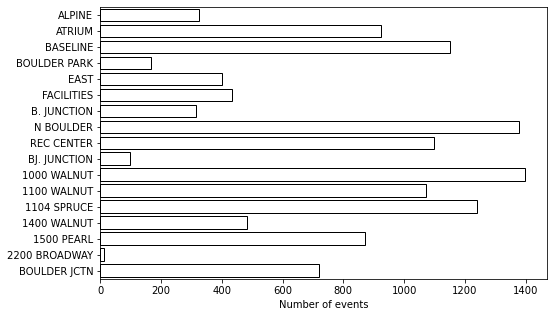

In [7]:
temp = df.groupby(['Station_Name']).count().latitude # group the data for each station
plt.rcParams['figure.figsize'] = (8,5) # Figure size
ax = sns.barplot(x=temp.values, y=stations_new, color='w', edgecolor='k')
#ax.axvline(31*10,color="Red", label="Minimum sample size")
#ax.axvline(1000, color="Blue", label="1000 sample size")
ax.set_xlabel("Number of events")
#ax.axvline(31*3,color="green", label="Minimum sample size, Applied stat....")
#ax.legend()
ax.set_ylabel("")
#ax.set_title("Observation count for each station")
plt.savefig('../visualization/event_counts_stations.pdf',bbox_inches='tight')
plt.show()

The 4 stations with most events.

In [8]:
stations4 = []

for i in range(0,len(temp)):
    if temp[i] >= 1100:
        stations4.append(temp.keys()[i])

In [10]:
df4 = df[df['Station_Name'].isin(stations4)]

## Time of day

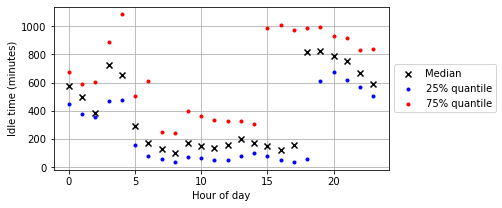

In [22]:
#plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(figsize=(6,3))
hour_of_day = np.arange(0,24)
medians1 = []
lower_q1 = []
upper_q1 = []

for hour in range(0,24):
    temp1 = df4[df4['hour_b'] == hour]
    medians1.append(temp1.life_time.median())
    lower_q1.append(temp1.life_time.quantile(0.25))
    upper_q1.append(temp1.life_time.quantile(0.75))

axs.scatter(hour_of_day, medians1, marker='x', color='k', label='Median')
axs.scatter(hour_of_day, lower_q1, marker='.', color='b', label='25% quantile')
axs.scatter(hour_of_day, upper_q1, marker='.', color='r', label='75% quantile')
axs.set_xlabel('Hour of day')
axs.set_ylabel('Idle time (minutes)')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_axisbelow(True)
#axs.set_title("[0-8] hours")
plt.grid()
plt.savefig('../visualization/tod_quantiles.pdf',bbox_inches='tight')
plt.show()

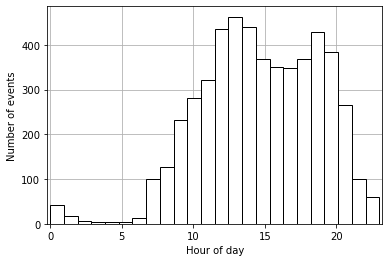

In [23]:
fig, axs = plt.subplots(figsize=(6,4))

axs.hist(df4.hour_b, color='w', edgecolor='k', bins=24)
axs.set_xlabel("Hour of day")
axs.set_ylabel("Number of events")
axs.set_xlim(-0.2,23.2)
plt.grid()
axs.set_axisbelow(True)
plt.savefig('../visualization/tod_counts.pdf',bbox_inches='tight')
plt.show()

## Day of week

In [24]:
['Monday','Thuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

['Monday', 'Thuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


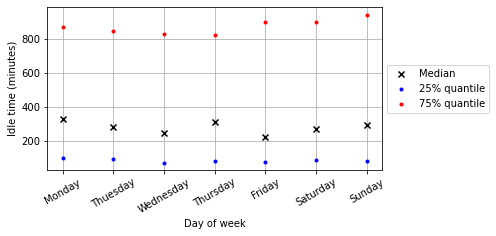

In [25]:
#plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(figsize=(6,3))
dow = ['Monday','Thuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
medians1 = []
lower_q1 = []
upper_q1 = []

for hour in range(0,7):
    temp1 = df8[df8['weekday_b'] == hour]
    medians1.append(temp1.life_time.median())
    lower_q1.append(temp1.life_time.quantile(0.25))
    upper_q1.append(temp1.life_time.quantile(0.75))

axs.scatter(dow, medians1, marker='x', color='k', label='Median')
axs.scatter(dow, lower_q1, marker='.', color='b', label='25% quantile')
axs.scatter(dow, upper_q1, marker='.', color='r', label='75% quantile')
axs.set_xlabel('Day of week')
axs.set_ylabel('Idle time (minutes)')
axs.set_xticklabels(dow,rotation=30)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_axisbelow(True)
plt.grid()
plt.savefig('../visualization/dow_quantiles.pdf',bbox_inches='tight')
plt.show()

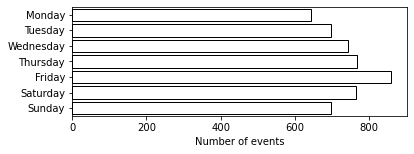

In [26]:
fig, axs = plt.subplots(figsize=(6,2))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
counts = df8.groupby('weekday_b').count().life_time.values
sns.barplot(y=weekdays, x=counts, color='w', edgecolor='k')
#axs.set_title("8+ hours")
axs.set_xlabel("Number of events")
plt.savefig('../visualization/dow_counts.pdf',bbox_inches='tight')
plt.show()